# ING Insights


Notebook used to categorize and automatically analyse transations data from ING Bank Account. This account is aggregation transaction information from all accounts in ING Bank as well as Millennium.

Analysis should be used to aggregate per month infomrations infomrations about spending, mainly from accounts `Wspólne`, `Osobiste`, `Millennium`.


**TODO**
- [ ] Export to Excel
- [ ] Different data analysis options
- [ ] Make mark in Excel file which rows were analysed by the tool. Alternatively records could be removed from `df`

## 01 - Importing data

Import data from ING Bank history export. Class used to import the data `TransactionDataLoader` consisting fetching mechanism with data sanitization finctionalities.

In [201]:
from pathlib import Path

from data_loader import *

csv_import_1 = Path("data/Lista_transakcji_nr_0202366310_201224.csv")
csv_import_2 = Path("data/20241220_lista_transkcji_ing_mill_90.csv")
csv_import_3 = Path("data/ing_12_2024.csv")

df_import = TransactionDataLoader(csv_import_3).get_data()
print(f"Successfully imported dataframe with size {df_import.shape}\n\n")



Successfully imported dataframe with size (226, 21)




## 02 - Data filtering


Filter only usefully columns for further data analysis. This will be the base for further analysis of data.

1. Columns should contain set of information which will be used for further analysis.
2. Values of `Kwota transakcji (waluta rachunku)` should be __negative__. Only expenses to be analysed.
3. Exclude own transfers.


In [202]:
selected_columns = ['Data transakcji', 'Dane kontrahenta', 'Tytuł', 'Kwota transakcji (waluta rachunku)', 'Bank']

# 1. Only useful columns used for analysis
df_c = df_import[selected_columns]

# 2. Remove rows with negative values in column ''Kwota transakcji (waluta rachunku)''
df_neg = df_c[df_c['Kwota transakcji (waluta rachunku)'] < 0]

# 3. Exclude own transfers
df_not = df_neg[df_neg["Tytuł"].str.contains("Przelew własny|Own transfer") == False]

# TODO: Lowercase all columns
# 4. Filter out not relevant transactions.
df = df_not[df_not["Dane kontrahenta"].str.contains("Albert|ALBERT|Raty|RATA|RATY|Rata") == False]

## 03 - Categorization


Define categories for analysis and fill the data based on filter definition applied to `Dane kontrachenta` in `df` data frame.

`ExpenseCategory` dataclass contains atrribute for sotring data filtered by applied filter.

Categorized expance data will be storred in `expense_category_list`


In [203]:
"""
Input data for analysis: df

ExpenceCategiries dataclass instance containing objects of expense category.
 - name: str
 - filter: str
 - sum: Optional[float]
 - data_frame: Optional[pd.DataFrame]
"""
expense_category_list = [
    ExpenseCategory(name="Zakupy spożywcze",
                    filter="LIDL|BIED|ZAB|PIEKARNIA|Zygula|Piekarstwo|CARREFOUR|FAMILIJNA|CENTRUM WINA|NETTO|AUCHAN"),
    ExpenseCategory(name="Kosmetyki",
                    filter="ROSSMANN|notino"),
    ExpenseCategory(name="Restauracje",
                    filter="PIAZZA|COCKPEAT|CHLEBOTEKA|WHISKEYINTHEJAR|TUTTI|NEWPORT CAFE|SHRIMP HOUSE"),
    ExpenseCategory(name="Zdrowie",
                    filter="APTEKA|LUX MED|SUPER-PHARM"),
    ExpenseCategory(name="Transport",
                    filter="SHELL|Myjnia|ORLEN|WROCLAVIA PARKING|Taxi|APCOA|Autopay|STACJA PALIW|CIRCLE K")
]

# Filter df dataframe and fill each ExpenseCategory data class attributes.
for i in range(len(expense_category_list)):
    expense_category_list[i].data_frame = df[
        df["Dane kontrahenta"].str.contains(expense_category_list[i].filter) == True]

    expense_category_list[i].sum = abs(
        round(float(expense_category_list[i].data_frame["Kwota transakcji (waluta rachunku)"].sum()), 2))

### 3.1 - Categorization helper

Based on data which is not matching any filter build better filter for transactions in account statement.

In [204]:
sep = "|"
flt_t = []

for exp in expense_category_list:
    flt_t.append(exp.filter)

# Transactions not matching defined filters.
n_df = df[df["Dane kontrahenta"].str.contains(sep.join(flt_t)) == False]

print(
    f"\x1b[31m"  # Colour output red
    f"Transactions not categorized: {n_df.shape[0]} with total sum of: "
    f"{round(n_df["Kwota transakcji (waluta rachunku)"].sum(), 2)} PLN"
    f"\x1b[0m")
n_df


Transactions not categorized: 72 with total sum of: -6901.05 PLN


,Data transakcji,Dane kontrahenta,Tytuł,Kwota transakcji (waluta rachunku),Bank
0,2024-12-25,BP-STANISLAWICE 296 TAAS KLAJ POL,Płatność kartą 25.12.2024 Nr karty 4246xx3990,-22.68,ING Bank Śląski S.A.
1,2024-12-25,ALLEGRO SP. Z O.O. ul. Wierzbiecice 1B Poznan,Płatność BLIK 25.12.2024 Nr transakcji 854447...,-68.00,ING Bank Śląski S.A.
3,2024-12-24,MEDIAEXPERT 02 SKARZYSKO-KAM POL,Płatność kartą 24.12.2024 Nr karty 4246xx0146,-129.99,ING Bank Śląski S.A.
14,2024-12-23,Salonik nr 266841 Kielce POL,Płatność kartą 23.12.2024 Nr karty 4246xx3990,-5.59,ING Bank Śląski S.A.
16,2024-12-23,BENGOL KEBAB SKARZYSKO-KAM POL,Płatność kartą 23.12.2024 Nr karty 4246xx3990,-39.00,ING Bank Śląski S.A.
...,...,...,...,...,...
206,2024-12-03,inpost.pl - konto główn PANA TADEUSZA 4 KRAKÓW,Płatność BLIK 03.12.2024 Nr transakcji 850096...,-11.99,ING Bank Śląski S.A.
213,2024-12-02,SALON FIRMOWY HOMLA WROCLAW POL,Płatność kartą 02.12.2024 Nr karty 4246xx8749,-108.99,ING Bank Śląski S.A.
219,2024-12-02,ZKH/1625/01/2023 92100702955,ZKH/1625/01/2023 92100702955,-125.89,Bank Millennium S.A
220,2024-12-02,ZKH/1625/01/2023 93012514720,ZKH/1625/01/2023 93012514720,-71.56,Bank Millennium S.A


## 04 - Plotting

Transform `expense_category_list` to data frame for ploting purpose.

In [205]:
from dataclasses import asdict

expense_dicts = [asdict(expense) for expense in expense_category_list]
plt_df = pd.DataFrame(expense_dicts)


Build plot to demonstrate expanse distribution.

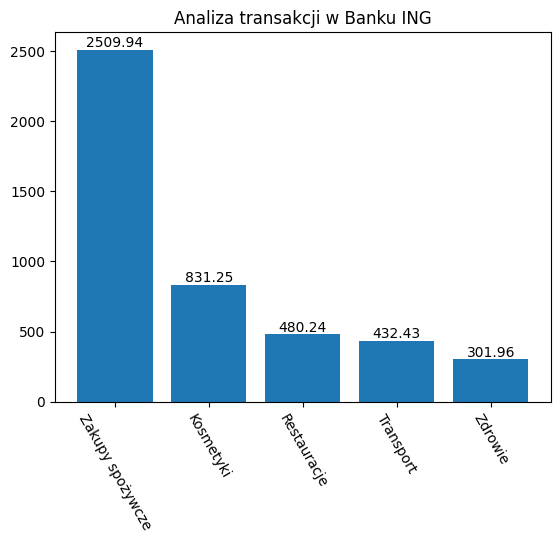

,name,sum
0,Zakupy spożywcze,2509.94
1,Kosmetyki,831.25
2,Restauracje,480.24
4,Transport,432.43
3,Zdrowie,301.96


In [206]:
import matplotlib.pyplot as plt
import numpy as np

categories = plt_df['name']
values = plt_df['sum']

# Sort data by values
sorted_indices = np.argsort(values)[::-1]  # Descending order
categories_sorted = [categories[i] for i in sorted_indices]
values_sorted = [values[i] for i in sorted_indices]

# Add data labels
for i, value in enumerate(values_sorted):
    plt.text(i, value + 0.5,  # Position slightly above the bar
             str(value),  # Label text
             ha='center',  # Horizontal alignment
             va='bottom')  # Vertical alignment

# Plot the bar chart
bars = plt.bar(categories_sorted, values_sorted)

# Configure plot
plt.xticks(rotation=-60)
plt.title('Analiza transakcji w Banku ING')

# Show the plot
plt.show()

# plt_df sorted by biggest sum value
plt_df.sort_values(by='sum', ascending=False)[['name', 'sum']]

## 99 - Debug

Debug categorized data based on filters defined. Use index <> expace mapping from Plotting section.

In [207]:
# Verification of category mapping, id of expense category above.

expense_category_list[0].data_frame


,Data transakcji,Dane kontrahenta,Tytuł,Kwota transakcji (waluta rachunku),Bank
10,2024-12-23,SKLEP LIDL 1134 SKA SKARZYSKO-KAM,Płatność kartą 23.12.2024 Nr karty 4246xx3990,-20.97,ING Bank Śląski S.A.
11,2024-12-23,SKLEP LIDL 1134 SKA SKARZYSKO-KAM,Płatność kartą 23.12.2024 Nr karty 4246xx3990,-104.24,ING Bank Śląski S.A.
25,2024-12-22,ZABKA Z8781 K.2 KIELCZOW 55093 POL,Płatność kartą 22.12.2024 Nr karty 4246xx3990,-28.48,ING Bank Śląski S.A.
39,2024-12-21,ZABKA Z1208 K.2 WROCLAW 51507 POL,Płatność kartą 21.12.2024 Nr karty 4246xx0146,-117.57,ING Bank Śląski S.A.
41,2024-12-21,"Piekarstwo"" Sp.J. LANY POL """,Płatność kartą 21.12.2024 Nr karty 4246xx3990,-32.72,ING Bank Śląski S.A.
43,2024-12-21,CARREFOUR SUPERMARKET WROCLAW POL,Płatność kartą 21.12.2024 Nr karty 4246xx8749,-10.54,ING Bank Śląski S.A.
53,2024-12-20,JMP S.A. BIEDRONKA 6270 DOBRZYKOWI,Płatność kartą 20.12.2024 Nr karty 4246xx0146,-70.47,ING Bank Śląski S.A.
57,2024-12-20,AUCHAN POLSKA SP. Z WROCLAW POL,Płatność kartą 20.12.2024 Nr karty 4246xx8749,-229.67,ING Bank Śląski S.A.
68,2024-12-19,LIDL STRACHOCINSKA WROCLAW POL,Płatność kartą 19.12.2024 Nr karty 4246xx8749,-182.51,ING Bank Śląski S.A.
70,2024-12-19,ZABKA Z5371 K.1 WROCLAW 51504 POL,Płatność kartą 19.12.2024 Nr karty 4246xx8749,-15.49,ING Bank Śląski S.A.
